# Cutting Trajectories

In [1]:
import os
os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())

working dir /home/tales/dev/master/mdc_analysis


In [2]:
import pandas as pd
import numpy as np
import math
import copy
import datetime
import gc

from bokeh.models import PrintfTickFormatter
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool

from src.dao import csv_dao, objects_dao
from src.plot.basic_plot import plot_result
from src.similarity.extreme_travelers import sequence_report
from src.data_processment.input_data_version import InputDataManager
from src.utils.time_utils import human_time

from src.data_processment.trajectory_cutting import gaps_params, cut_traj_in_trips

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
output_notebook()

Loading BokehJS ...

## Loading User Data

In [5]:
# users_srg = objects_dao.load_all_stop_region_group_object()
# users_tags = objects_dao.load_users_tags_sequence(sr_stay_time_above_h=0.5)["orignal"]

In [6]:
users_gps_dir = os.listdir("outputs/user_gps/")
users_gps = {}

for user_gps_dir in users_gps_dir:
    user = user_gps_dir.split("_")[0]
    users_gps[user] = csv_dao.load_user_gps_csv(user)

## Gaps

How many gaps above 06h ? <br> 
How many gaps above 12h ? <br> 
How many gaps above 24h ? <br>
How many gaps above 48h ? <br>
How much time the user has participated?

In [7]:
def gap_missing_values(report):
    t2 = report.iloc[1:len(report)]["local_time"].astype(float).reset_index(drop=True)
    t1 = report.iloc[0:len(report) - 1]["local_time"].astype(float).reset_index(drop=True)
    gaps = t2 - t1
    gaps.index = report.iloc[1:len(report)]["local_time"]
    head = pd.Series([None], index=[t1.iloc[0].item()])
    return head.append(gaps)

def gap_amount(gap, min_time_h):
    present_data_sum = gap[gap <= 60 * 60 * min_time_h].sum()
    missing_data_sum = gap[gap > 60 * 60 * min_time_h].sum()
    
    return {"missing_data_sum": missing_data_sum, "present_data_sum": present_data_sum}

def user_time_participation(report):
    first = report["local_time"].min()
    last = report["local_time"].max()
    
    n_days = (last - first) / (60*60*24)
    
    return {"n_days": n_days,
            "n_years": n_days / 365.25,
            "datetime_start": human_time(first, datetime_format='%d-%m-%Y %H:%M:%S')["datetime"],
            "datetime_end": human_time(last, datetime_format='%d-%m-%Y %H:%M:%S')["datetime"]}
    
def gaps_summary(gaps, min_time_h):
    selection = gaps[gaps > 60 * 60 * min_time_h]
    return {"n_gaps": len(selection),
            "median_sec": selection.median(),
            "min_time_gap": min_time_h}

def merge_dicts(dicts):
    final_dict = {}
    
    for d in dicts:
        
        for k in d.keys():
            final_dict[k] = d[k]

    return final_dict

#gaps per week
def gaps_week(gaps, user_data, min_time_h): 
    gaps_df = pd.DataFrame({"gaps": gaps.tolist(), "local_time": user_data["local_time"][0:-1].tolist()})
    gaps_df["week"] = ((gaps_df["local_time"] - gaps_df["local_time"].min()) / (60*60*24*7)).apply(math.floor)
    
    return gaps_df[gaps_df["gaps"] > 60*60*min_time_h]

# Cutting Trajectories

In [8]:
users_gps["5937"].head()

,latitude,longitude,speed,horizontal_accuracy,vertical_accuracy,speed_accuracy,altitude,horizontal_dop,vertical_dop,db_key,userid,tz,time,type,local_time
4052,46.31,6.97,nan,82.59,55.50,nan,450.50,7.23,5.63,81673215,5937,-3600,1253637575,gps,1253633975
12127,46.31,6.97,54.00,81.21,62.00,10.08,467.50,4.77,3.15,81673216,5937,-3600,1253637585,gps,1253633985
18542,46.31,6.97,87.05,42.90,34.50,3.42,467.00,4.77,3.14,81673217,5937,-3600,1253637595,gps,1253633995
7521,46.31,6.96,68.29,99.69,66.00,1.98,465.50,7.15,5.53,81673218,5937,-3600,1253637605,gps,1253634005
643,46.32,6.96,48.85,33.83,30.50,5.69,464.50,2.41,2.29,81673223,5937,-3600,1253637615,gps,1253634015


In [9]:
# def gaps_params(user_gps_data, gap_tresh_minutes):
#     start_stop_gaps = []
    
#     gaps_data = gap_missing_values(user_gps_data).to_frame().reset_index().rename({0: "gap_time", "index": "stop"}, axis=1)
    
#     gaps_data["start"] = [None] + gaps_data.iloc[0 : len(gaps_data) - 1]["stop"].tolist()
#     gaps_data["start"] = gaps_data["start"].replace({np.NaN: None})
    
#     selected_gaps = copy.deepcopy(gaps_data[gaps_data["gap_time"] > gap_tresh_minutes * 60])
    
#     selected_gaps["user_id"] = user_gps_data["userid"].drop_duplicates().item()
    
#     return selected_gaps[["user_id", "gap_time", "start", "stop"]]
    
gaps_times = gaps_params(users_gps["5937"], 30)
gaps_times.head(6)

,user_id,gap_time_sec,start,stop
245,5937,15651.00,1253639643.00,1253655294.00
253,5937,26816.00,1253655703.00,1253682519.00
329,5937,865123.00,1253683561.00,1254548684.00
844,5937,4801.00,1254557227.00,1254562028.00
1897,5937,56784.00,1254580460.00,1254637244.00
1976,5937,8506.00,1254638336.00,1254646842.00


In [10]:
# gaps_times.head(6).to_dict(orient="records")

# Applying Trajectories Cut To InputDataManager

In [11]:
data_manager = InputDataManager(use_cache=False)

Loading Users Sequence Report
Loading user_id: 6189 - 1 out of 163
Loading user_id: 5936 - 2 out of 163
Loading user_id: 6087 - 3 out of 163
Loading user_id: 5973 - 4 out of 163
Loading user_id: 6085 - 5 out of 163
Loading user_id: 6074 - 6 out of 163
Loading user_id: 6012 - 7 out of 163
Loading user_id: 5982 - 8 out of 163
Loading user_id: 5948 - 9 out of 163
Loading user_id: 5974 - 10 out of 163
Loading user_id: 6090 - 11 out of 163
Loading user_id: 6199 - 12 out of 163
Loading user_id: 6068 - 13 out of 163
Loading user_id: 6024 - 14 out of 163
Loading user_id: 5976 - 15 out of 163
Loading user_id: 6094 - 16 out of 163
Loading user_id: 5941 - 17 out of 163
Loading user_id: 5995 - 18 out of 163
Loading user_id: 5962 - 19 out of 163
Loading user_id: 6093 - 20 out of 163
Loading user_id: 6033 - 21 out of 163
Loading user_id: 6079 - 22 out of 163
Loading user_id: 6038 - 23 out of 163
Loading user_id: 6175 - 24 out of 163
Loading user_id: 6042 - 25 out of 163
Loading user_id: 5924 - 26 ou

In [12]:
# input_data = {}

# for version in data_manager.avaliable_versions():
#     print("version:", version)
#     input_data[version] = {}
#     for sr_min_time in [5,15,30]:
#         print("sr_min_time:", sr_min_time)
#         input_data[version][sr_min_time] = data_manager.get_input_data(version=version, sr_stay_time_minutes=sr_min_time)


#### Loading User GPS data

In [13]:
user_id = "5936"
user_gps_data = csv_dao.load_user_gps_csv(user_id)

#### Gaps

In [14]:
gaps = gaps_params(user_gps_data, gap_tresh_minutes=60 * 12)
print("Counting gaps:", len(gaps))
gaps.head()

Counting gaps: 367


,user_id,gap_time_sec,start,stop
142,5936,43424.00,1253806201.00,1253849625.00
214,5936,48209.00,1253894062.00,1253942271.00
291,5936,72012.00,1253966959.00,1254038971.00
1348,5936,92524.00,1254054871.00,1254147395.00
1400,5936,44771.00,1254150133.00,1254194904.00


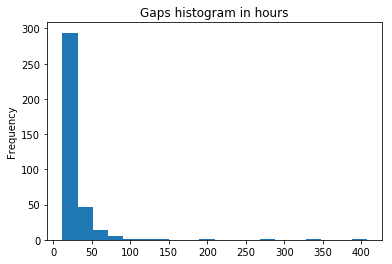

In [15]:
(gaps["gap_time_sec"] / (60*60)).plot.hist(bins=20, title="Gaps histogram in hours")

#### Loading User Stop Region Group

In [16]:
print("USER ID:", user_id)
user_srg = objects_dao.load_stop_region_group_object(user_id)
seq = user_srg.sequence_report(enrich_columns=True)
seq = seq[["sr_start_time", "sr_end_time", "tags", "start_date", "start_time", "end_date", "end_time"]]
seq["gap_mins"] = (seq["sr_end_time"] - seq["sr_start_time"]) / 60.
print("Counting Stop Region Stops", len(seq))
seq.head()

USER ID: 5936
Counting Stop Region Stops 466


,sr_start_time,sr_end_time,tags,start_date,start_time,end_date,end_time,gap_mins
0,1253851684.00,1253852031.00,"[liquor_store, convenience_store, restaurant, ...",2009-09-25,04:08:04,2009-09-25,04:13:51,5.78
1,1253852071.00,1253867442.00,[WORK],2009-09-25,04:14:31,2009-09-25,08:30:42,256.18
2,1254042356.00,1254042912.00,"[locality, political]",2009-09-27,09:05:56,2009-09-27,09:15:12,9.27
3,1254043814.00,1254044738.00,[lodging],2009-09-27,09:30:14,2009-09-27,09:45:38,15.40
4,1254150133.00,1254194904.00,[HOME],2009-09-28,15:02:13,2009-09-29,03:28:24,746.18


#### Viewing Gaps and Stop Regions

In [17]:
from bokeh.plotting import figure, ColumnDataSource, output_notebook, show
output_notebook()    

Loading BokehJS ...

In [ ]:
data_manager = InputDataManager(use_cache=True)

Loading Users Sequence Report


In [ ]:
users_categs = data_manager.get_input_data(version="0.0.categ_v1")["user_data"]
# data_manager = None
# gc.collect()

In [ ]:
seq.head()

In [ ]:
def gaps_tooltips():
    return [
        ("start_date", "@start_date"),
        ("start_time", "@start_time"),
        ("end_date", "@end_date"),
        ("end_time", "@end_time"),
        ("length_h", "@length_h"),
        ("length_m", "@length_m")
    ]

def sr_tooltips():
    return [
        ("sr_id", "@sr_id"),
        ("categ", "@categ"),
        ("start_date", "@start_date"),
        ("start_time", "@start_time"),
        ("end_date", "@end_date"),
        ("end_time", "@end_time"),
        ("length_h", "@length_h"),
        ("length_m", "@length_m")
    ]

def fomart_stop_regions_group_data_source(user_stop_regions_group, user_categs):
    seq = user_stop_regions_group.sequence_report(enrich_columns=True)
    
    stop_regions_length = seq["sr_end_time"] - seq["sr_start_time"]
    
    return ColumnDataSource(data=dict(
        sr_id=seq["sr"],
        categ=user_categs,
        sr_lines = [ [seq["sr_start_time"].iloc[i] * 1000, seq["sr_end_time"].iloc[i] * 1000] for i in range(len(seq))],
        xaxis=[[0,0]] * len(seq),
        length_h=stop_regions_length / (60 * 60),
        length_m=stop_regions_length / (60),
        start_date=seq["start_date"],
        start_time=seq["start_time"],
        end_date=seq["end_date"],
        end_time=seq["end_time"],
        tags=user_categs
    ))

def fomart_gaps_data_source(gaps, user_categs):
    gaps_start_time = gaps['start']
    gaps_length = gaps['gap_time_sec']
    
    gaps_data = pd.DataFrame({"gaps_start_time": gaps_start_time, "gaps_length": gaps_length})
    
    start_date = gaps['start'].apply(lambda ts : datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d'))
    start_time = gaps['start'].apply(lambda ts : datetime.datetime.utcfromtimestamp(ts).strftime('%H:%M:%S'))
    
    gaps_end_time = gaps_start_time + gaps_length
    end_date = gaps_end_time.apply(lambda ts : datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d'))
    end_time = gaps_end_time.apply(lambda ts : datetime.datetime.utcfromtimestamp(ts).strftime('%H:%M:%S'))
    
    gaps_lines = [ [gaps_start_time.iloc[i] * 1000, gaps_start_time.iloc[i] * 1000 + gaps_length.iloc[i] * 1000] for i in range(len(gaps_start_time))]

    return ColumnDataSource(data=dict(
        gaps_lines=gaps_lines,
        xaxis=[[0,0]] * len(gaps_start_time),
        length_h=gaps_length / (60 * 60),
        length_m=gaps_length / (60),
        start_date=start_date,
        start_time=start_time,
        end_date=end_date,
        end_time=end_time
    ))
    

def plot_gaps_srg(gaps, stop_regions, user_categs, line_width=6):
    p = figure(plot_width=900, 
           plot_height=300, 
           x_axis_type='datetime', 
           tools=['pan', 'xwheel_zoom', 'reset'])
    
    if not gaps is None:
        gaps_source = fomart_gaps_data_source(gaps, user_categs)
        p_gaps = p.multi_line("gaps_lines",
                     "xaxis",
                     color="magenta",
                     line_width=line_width,
                     legend="gaps",
                     source=gaps_source)
        
        p.add_tools(HoverTool(renderers=[p_gaps], tooltips=gaps_tooltips()))

    if not stop_regions is None:
        sr_source = fomart_stop_regions_group_data_source(stop_regions, user_categs)

        p_sr = p.multi_line("sr_lines",
                     "xaxis",
                     color="navy",
                     line_width=line_width,
                     legend="stop_regions",
                     source=sr_source)
        
        p.add_tools(HoverTool(renderers=[p_sr], tooltips=sr_tooltips()))
    
    return p

In [ ]:
p = plot_gaps_srg(gaps=gaps, stop_regions=user_srg, user_categs=users_categs[user_id], line_width=30)
show(p)

In [ ]:
p = plot_gaps_srg(gaps=gaps, stop_regions=user_srg, user_categs=users_categs[user_id], line_width=30)
show(p)

In [ ]:
cut = cut_traj_in_trips(srg_sequence_report=user_srg.sequence_report(enrich_columns=True), gaps=gaps)
pd.Series(cut).apply(len).value_counts()

In [ ]:
# def fomart_stop_regions_group_data_source(user_stop_regions_group, user_categs):
#     seq = stop_regions.sequence_report(enrich_columns=True)
#     stop_regions_start_time = seq["sr_start_time"] * 1000
#     stop_regions_length = ((seq["sr_end_time"] * 1000) - stop_regions_start_time)
#     sr_data = pd.DataFrame({"sr_start_time": stop_regions_start_time, "sr_len": stop_regions_length})
    
    
#     return ColumnDataSource(data=dict(
#         sr_id=seq["sr"],
#         categ=categ,
#         length_milli=stop_regions_length,
#         length_h=stop_regions_length / (1000 * 60 * 60),
#         start_date=seq["start_date"],
#         start_time=seq["start_time"],
#         end_date=seq["end_date"],
#         end_time=seq["end_time"],
#         tags=user_categs
#     ))

# def fomart_gaps_data_source(gaps, user_categs):
#     gaps_start_time = gaps['start']
#     gaps_length = gaps['gap_time_sec']
#     gaps_data = pd.DataFrame({"gaps_start_time": gaps_start_time, "gaps_length": gaps_length})
    
#     start_date = gaps['start'].apply(lambda ts : datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d'))
#     start_time = gaps['start'].apply(lambda ts : datetime.datetime.utcfromtimestamp(ts).strftime('%H:%M:%S'))
    
#     gaps_end_time = gaps_start_time + gaps_length
#     end_date = gaps_end_time.apply(lambda ts : datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d'))
#     end_time = gaps_end_time.apply(lambda ts : datetime.datetime.utcfromtimestamp(ts).strftime('%H:%M:%S'))
    
#     return ColumnDataSource(data=dict(
#         gaps_start_ts=gaps_start_time * 1000,
#         gaps_end_ts=gaps_start_time * 1000 + gaps_length * 1000,
#         length_h=gaps_length / (1000 * 60 * 60),
#         start_date=start_date,
#         start_time=start_time,
#         end_date=end_date,
#         end_time=end_time
#     ))
    

# def plot_gaps_srg(gaps, stop_regions, user_categs, line_width=6):
#     gaps_start_time = gaps['start'] * 1000
#     gaps_length = gaps['gap_time_sec'] * 1000
#     gaps_data = pd.DataFrame({"gaps_start_time": gaps_start_time, "gaps_length": gaps_length})
    
    
#     seq = stop_regions.sequence_report(enrich_columns=True)
#     stop_regions_start_time = seq["sr_start_time"] * 1000
#     stop_regions_length = ((seq["sr_end_time"] * 1000) - stop_regions_start_time)
#     sr_data = pd.DataFrame({"sr_start_time": stop_regions_start_time, "sr_len": stop_regions_length})
    
 
#     p = figure(plot_width=900, 
#                plot_height=400, 
#                x_axis_type='datetime', 
#                tools=['pan', 'xwheel_zoom', 'reset'])
    
#     #Gaps
#     print(len(gaps_data), "gaps_data")
#     gaps_data.apply(lambda row : p.line([row["gaps_start_time"], 
#                                          row["gaps_start_time"] + row["gaps_length"]], 
#                                          [0, 0], 
#                                          color="magenta",
#                                          line_width=line_width,
#                                          legend="gaps"), axis=1)

#     #Stop Regions
#     print(len(sr_data), "sr_data")
#     sr_data.apply(lambda row : p.line([row["sr_start_time"], 
#                                        row["sr_start_time"] + row["sr_len"]], 
#                                        [0, 0], 
#                                        color="navy",
#                                        line_width=line_width,
#                                        legend="stop_region"), axis=1)
#     p.yaxis.visible = False
#     return p